In [1]:
%load_ext autoreload
%autoreload 2

# IQA tracking params and variables

> When using parametric layers we have to be able to keep track of the parameters and the variables of the model (which are not going to be trained). We're going to play with this concept using our implementation of the functional layers.

In [2]:
# import os; os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".99"

In [3]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from typing import Any, Callable, Sequence, Union
import numpy as np

import tensorflow as tf
tf.config.set_visible_devices([], device_type='GPU')

import jax
from jax import lax, random, numpy as jnp
import flax
from flax.core import freeze, unfreeze, FrozenDict
from flax import linen as nn
from flax import struct
from flax.training import train_state
from flax.training import orbax_utils

import optax
import orbax.checkpoint

from clu import metrics
from ml_collections import ConfigDict

from einops import reduce, rearrange
import wandb
from iqadatasets.datasets import *
from fxlayers.layers import *
from fxlayers.layers import GaborLayerLogSigma_
from fxlayers.initializers import *
from JaxPlayground.utils.constraints import *
from JaxPlayground.utils.wandb import *

2023-11-30 15:06:17.753965: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-30 15:06:37.278549: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-11-30 15:07:19.210806: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-11-30 15:07:19.213336: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: mlui02.ific.uv.es
2023-11-30 15:07:19.214437: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: mlui02.ific.uv.es
2023-11-30 15:07:19.214625: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagno

In [4]:
# jax.config.update("jax_debug_nans", False)

## Load the data

> We're going to employ `iqadatasets` to ease the loading of the data.

In [5]:
dst_train = TID2008("/lustre/ific.uv.es/ml/uv075/Databases/IQA//TID/TID2008/", exclude_imgs=[25])
# dst_train = KADIK10K("/lustre/ific.uv.es/ml/uv075/Databases/IQA/KADIK10K/")
dst_val = TID2013("/lustre/ific.uv.es/ml/uv075/Databases/IQA//TID/TID2013/", exclude_imgs=[25])
# dst_train = TID2008("/media/disk/databases/BBDD_video_image/Image_Quality//TID/TID2008/", exclude_imgs=[25])
# dst_val = TID2013("/media/disk/databases/BBDD_video_image/Image_Quality//TID/TID2013/", exclude_imgs=[25])
# dst_train = TID2008("/media/databases/IQA/TID/TID2008/", exclude_imgs=[25])
# dst_val = TID2013("/media/databases/IQA/TID/TID2013/", exclude_imgs=[25])

In [6]:
img, img_dist, mos = next(iter(dst_train.dataset))
img.shape, img_dist.shape, mos.shape

2023-11-30 15:07:35.900918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [1632]
	 [[{{node Placeholder/_2}}]]


(TensorShape([384, 512, 3]), TensorShape([384, 512, 3]), TensorShape([]))

In [7]:
img, img_dist, mos = next(iter(dst_val.dataset))
img.shape, img_dist.shape, mos.shape

2023-11-30 15:07:36.617063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [2880]
	 [[{{node Placeholder/_2}}]]


(TensorShape([384, 512, 3]), TensorShape([384, 512, 3]), TensorShape([]))

In [8]:
config = {
    "BATCH_SIZE": 64,
    "EPOCHS": 500,
    "LEARNING_RATE": 3e-3,
    "SEED": 42,
    "GDN_CLIPPING": True,
    "NORMALIZE_PROB": False,
    "NORMALIZE_ENERGY": True,
    "ZERO_MEAN": True,
    "USE_BIAS": False,
    "CS_KERNEL_SIZE": 21,
    "GABOR_KERNEL_SIZE": 31,
    "N_SCALES": 4,
    "N_ORIENTATIONS": 8,
}
config = ConfigDict(config)
config

BATCH_SIZE: 64
CS_KERNEL_SIZE: 21
EPOCHS: 500
GABOR_KERNEL_SIZE: 31
GDN_CLIPPING: true
LEARNING_RATE: 0.0003
NORMALIZE_ENERGY: true
NORMALIZE_PROB: false
N_ORIENTATIONS: 8
N_SCALES: 4
SEED: 42
USE_BIAS: false
ZERO_MEAN: true

In [9]:
wandb.init(project="PerceptNet_v15",
           name="DN_OG_G_Fixed_Symm_CSPos",
           job_type="testing",
           config=config,
           mode="online",
           )
config = config
config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


BATCH_SIZE: 64
CS_KERNEL_SIZE: 21
EPOCHS: 500
GABOR_KERNEL_SIZE: 31
GDN_CLIPPING: true
LEARNING_RATE: 0.0003
NORMALIZE_ENERGY: true
NORMALIZE_PROB: false
N_ORIENTATIONS: 8
N_SCALES: 4
SEED: 42
USE_BIAS: false
ZERO_MEAN: true

In [10]:
dst_train_rdy = dst_train.dataset.shuffle(buffer_size=100,
                                      reshuffle_each_iteration=True,
                                      seed=config.SEED)\
                                 .batch(config.BATCH_SIZE, drop_remainder=True)
dst_val_rdy = dst_val.dataset.batch(config.BATCH_SIZE, drop_remainder=True)

## Define the model we're going to use

> It's going to be a very simple model just for demonstration purposes.

In [11]:
def pad_same_from_kernel_size(inputs, kernel_size, mode):
    return jnp.pad(inputs,
                   [[0,0],
                    [(kernel_size-1)//2, (kernel_size-1)//2],
                    [(kernel_size-1)//2, (kernel_size-1)//2],
                    [0,0]],
                    mode=mode)

In [12]:
class PerceptNet(nn.Module):
    """IQA model inspired by the visual system."""

    @nn.compact
    def __call__(self,
                 inputs, # Assuming fs = 128 (cpd)
                 **kwargs,
                 ):
        ## (Independent) Color equilibration (Gamma correction)
        ## Might need to be the same for each number
        ## bias = 0.1 / kernel = 0.5
        outputs = GDN(kernel_size=(1,1), apply_independently=True)(inputs)
        
        ## Color (ATD) Transformation
        outputs = nn.Conv(features=3, kernel_size=(1,1), use_bias=False)(outputs)
        outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))
        
        ## GDN Star A - T - D [Separated]
        outputs = GDN(kernel_size=(1,1), apply_independently=True)(outputs)

        ## Center Surround (DoG)
        ## Initialized so that 3 are positives and 3 are negatives and no interaction between channels is present
        outputs = pad_same_from_kernel_size(outputs, kernel_size=config.CS_KERNEL_SIZE, mode="symmetric")
        outputs = CenterSurroundLogSigmaK(features=3, kernel_size=config.CS_KERNEL_SIZE, fs=21, use_bias=False, padding="VALID")(outputs, **kwargs)
        outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))

        ## GDN per channel with mean substraction in T and D (Spatial Gaussian Kernel)
        ### fs = 32 / kernel_size = (11,11) -> 0.32 > 0.02 --> OK!
        ## TO-DO: - Spatial Gaussian Kernel (0.02 deg) -> fs = 64/2 & 0.02*64/2 = sigma (px) = 0.69
        outputs = GDN(kernel_size=(1,1), apply_independently=True)(outputs)

        ## GaborLayer per channel with GDN mixing only same-origin-channel information
        ### [Gaussian] sigma = 0.2 (deg) fs = 32 / kernel_size = (21,21) -> 21/32 = 0.66 --> OK!
        outputs = pad_same_from_kernel_size(outputs, kernel_size=config.GABOR_KERNEL_SIZE, mode="symmetric")
        outputs = GaborLayerLogSigma_(n_scales=config.N_SCALES, n_orientations=config.N_ORIENTATIONS, kernel_size=config.GABOR_KERNEL_SIZE, fs=32, xmean=config.GABOR_KERNEL_SIZE/32/2, ymean=config.GABOR_KERNEL_SIZE/32/2, strides=1, padding="VALID", normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY, zero_mean=config.ZERO_MEAN, use_bias=config.USE_BIAS)(outputs, **kwargs)
        
        ## Final GDN mixing Gabor information (?)
        outputs = GDN(kernel_size=(1,1), apply_independently=False)(outputs)
        return outputs

## Define the metrics with `clu`

In [13]:
@struct.dataclass
class Metrics(metrics.Collection):
    """Collection of metrics to be tracked during training."""
    loss: metrics.Average.from_output("loss")

By default, `TrainState` doesn't include metrics, but it's very easy to subclass it so that it does:

In [14]:
class TrainState(train_state.TrainState):
    metrics: Metrics
    state: FrozenDict

We'll define a function that initializes the `TrainState` from a module, a rng key and some optimizer:

In [15]:
def create_train_state(module, key, tx, input_shape):
    """Creates the initial `TrainState`."""
    variables = module.init(key, jnp.ones(input_shape))
    state, params = variables.pop('params')
    return TrainState.create(
        apply_fn=module.apply,
        params=params,
        state=state,
        tx=tx,
        metrics=Metrics.empty()
    )

## Defining the training step

> We want to write a function that takes the `TrainState` and a batch of data can performs an optimization step.

In [16]:
def pearson_correlation(vec1, vec2):
    vec1 = vec1.squeeze()
    vec2 = vec2.squeeze()
    vec1_mean = vec1.mean()
    vec2_mean = vec2.mean()
    num = vec1-vec1_mean
    num *= vec2-vec2_mean
    num = num.sum()
    denom = jnp.sqrt(jnp.sum((vec1-vec1_mean)**2))
    denom *= jnp.sqrt(jnp.sum((vec2-vec2_mean)**2))
    return num/denom

In [17]:
from functools import partial

In [18]:
@partial(jax.jit, static_argnums=2)
def train_step(state, batch, return_grads=False):
    """Train for a single step."""
    img, img_dist, mos = batch
    def loss_fn(params):
        ## Forward pass through the model
        img_pred, updated_state = state.apply_fn({"params": params, **state.state}, img, mutable=list(state.state.keys()), train=True)
        img_dist_pred, updated_state = state.apply_fn({"params": params, **state.state}, img_dist, mutable=list(state.state.keys()), train=True)

        ## Calculate the distance
        dist = ((img_pred - img_dist_pred)**2).sum(axis=(1,2,3))**(1/2)
        
        ## Calculate pearson correlation
        return pearson_correlation(dist, mos), updated_state
    
    (loss, updated_state), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)
    metrics_updates = state.metrics.single_from_model_output(loss=loss)
    metrics = state.metrics.merge(metrics_updates)
    state = state.replace(metrics=metrics)
    state = state.replace(state=updated_state)
    if return_grads: return state, grads
    else: return state

In their example, they don't calculate the metrics at the same time. I think it is kind of a waste because it means having to perform a new forward pass, but we'll follow as of now. Let's define a function to perform metric calculation:

In [19]:
@jax.jit
def compute_metrics(*, state, batch):
    """Obtaining the metrics for a given batch."""
    img, img_dist, mos = batch
    def loss_fn(params):
        ## Forward pass through the model
        img_pred, updated_state = state.apply_fn({"params": params, **state.state}, img, mutable=list(state.state.keys()), train=False)
        img_dist_pred, updated_state = state.apply_fn({"params": params, **state.state}, img_dist, mutable=list(state.state.keys()), train=False)

        ## Calculate the distance
        dist = ((img_pred - img_dist_pred)**2).sum(axis=(1,2,3))**(1/2)
        
        ## Calculate pearson correlation
        return pearson_correlation(dist, mos)
    
    metrics_updates = state.metrics.single_from_model_output(loss=loss_fn(state.params))
    metrics = state.metrics.merge(metrics_updates)
    state = state.replace(metrics=metrics)
    return state

## Train the model!

In [20]:
state = create_train_state(PerceptNet(), random.PRNGKey(config.SEED), optax.adam(config.LEARNING_RATE), input_shape=(1,384,512,3))
state = state.replace(params=clip_layer(state.params, "GDN", a_min=0))
state = state.replace(params=clip_param(state.params, "A", a_min=0))

In [21]:
pred, _ = state.apply_fn({"params": state.params, **state.state}, jnp.ones(shape=(1,384,512,3)), train=True, mutable=list(state.state.keys()))

In [22]:
import matplotlib.pyplot as plt

In [23]:
def plot_filters(kernel):
    kx, ky, cin, cout = kernel.shape
    fig, axes = plt.subplots(cin, cout, squeeze=False)
    for i in range(cin):
        for j in range(cout):
            axes[i,j].imshow(kernel[:,:,i,j])
            axes[i,j].axis("off")
    plt.show()

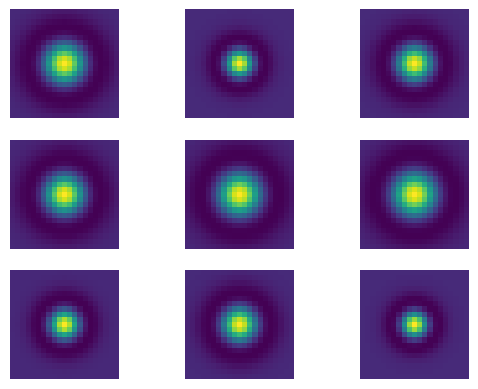

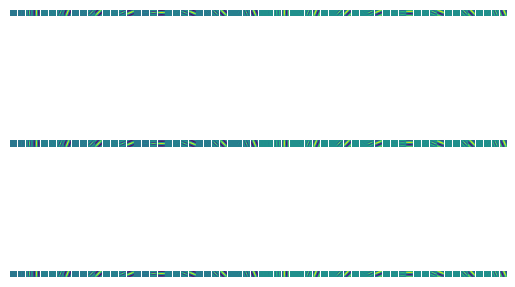

In [24]:
__ = jax.tree_util.tree_map(lambda x: plot_filters(x), _)

In [25]:
def check_trainable(path):
    # return ("A" in path) or ("alpha_chrom_rg" in path) or ("alpha_chrom_yb" in path)
    return False

In [26]:
trainable_tree = freeze(flax.traverse_util.path_aware_map(lambda path, v: "non_trainable" if check_trainable(path)  else "trainable", state.params))
trainable_tree

FrozenDict({
    GDN_0: {
        Conv_0: {
            kernel: 'trainable',
            bias: 'trainable',
        },
    },
    Conv_0: {
        kernel: 'trainable',
    },
    GDN_1: {
        Conv_0: {
            kernel: 'trainable',
            bias: 'trainable',
        },
    },
    CenterSurroundLogSigmaK_0: {
        logsigma: 'trainable',
        K: 'trainable',
        A: 'trainable',
    },
    GDN_2: {
        Conv_0: {
            kernel: 'trainable',
            bias: 'trainable',
        },
    },
    GaborLayerLogSigma__0: {
        freq: 'trainable',
        logsigmax2: 'trainable',
        logsigmay2: 'trainable',
        theta: 'trainable',
        sigma_theta: 'trainable',
    },
    GDN_3: {
        Conv_0: {
            kernel: 'trainable',
            bias: 'trainable',
        },
    },
})

In [27]:
optimizers = {
    "trainable": optax.adam(learning_rate=config.LEARNING_RATE),
    "non_trainable": optax.set_to_zero(),
}

In [28]:
tx = optax.multi_transform(optimizers, trainable_tree)

In [29]:
state = create_train_state(PerceptNet(), random.PRNGKey(config.SEED), tx, input_shape=(1,384,512,3))
state = state.replace(params=clip_layer(state.params, "GDN", a_min=0))

In [30]:
param_count = sum(x.size for x in jax.tree_util.tree_leaves(state.params))
trainable_param_count = sum([w.size if t=="trainable" else 0 for w, t in zip(jax.tree_util.tree_leaves(state.params), jax.tree_util.tree_leaves(trainable_tree))])
param_count, trainable_param_count

(4242, 4242)

In [31]:
wandb.run.summary["total_parameters"] = param_count
wandb.run.summary["trainable_parameters"] = trainable_param_count

In [44]:
state = state.replace(params=unfreeze(state.params))

# ## DN 0 (Gamma)
state.params["GDN_0"]["Conv_0"]["bias"] = jnp.ones_like(state.params["GDN_0"]["Conv_0"]["bias"])*0.1
state.params["GDN_0"]["Conv_0"]["kernel"] = jnp.ones_like(state.params["GDN_0"]["Conv_0"]["kernel"])*0.5

## Center Surround
state.params["CenterSurroundLogSigmaK_0"]["K"] = jnp.array([1.1,1.01,1.01,
                                                            1.01,1.1,1.01,
                                                            1.01,1.01,1.1])
state.params["CenterSurroundLogSigmaK_0"]["A"] = jnp.array([1.,0.,0.,
                                                            0.,1.,0.,
                                                            0.,0.,1.])

state = state.replace(params=freeze(state.params))

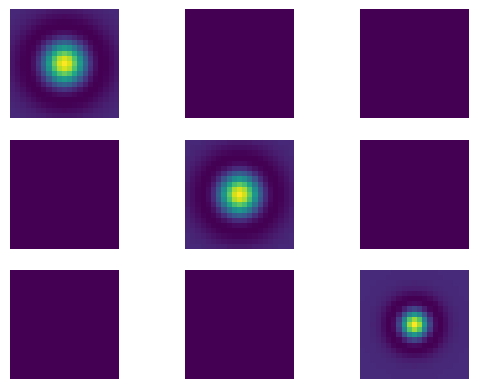

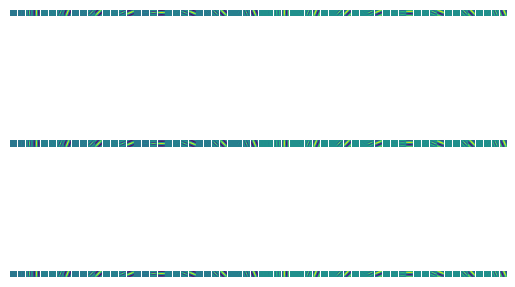

In [45]:
pred, _ = state.apply_fn({"params": state.params, **state.state}, jnp.ones(shape=(1,384,512,3)), train=True, mutable=list(state.state.keys()))
__ = jax.tree_util.tree_map(lambda x: plot_filters(x), _)

Before actually training the model we're going to set up the checkpointer to be able to save our trained models:

In [46]:
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
save_args = orbax_utils.save_args_from_target(state)

In [47]:
metrics_history = {
    "train_loss": [],
    "val_loss": [],
}

In [48]:
batch = next(iter(dst_train_rdy.as_numpy_iterator()))

In [49]:
from functools import partial

In [50]:
@jax.jit
def forward(state, inputs):
    return state.apply_fn({"params": state.params, **state.state}, inputs, train=False)

In [51]:
@jax.jit
def forward_intermediates(state, inputs):
    return state.apply_fn({"params": state.params, **state.state}, inputs, train=False, capture_intermediates=True)

In [52]:
%%time
outputs = forward(state, batch[0])
outputs.shape

CPU times: user 2min 9s, sys: 593 ms, total: 2min 10s
Wall time: 2.53 s


(64, 56, 88, 64)

In [53]:
%%time
s1, grads = train_step(state, batch, return_grads=True)

CPU times: user 14min 5s, sys: 38.1 s, total: 14min 43s
Wall time: 24.3 s


In [54]:
# jax.config.update("jax_debug_nans", True)

In [41]:
%%time
for epoch in range(config.EPOCHS):
    ## Training
    for batch in dst_train_rdy.as_numpy_iterator():
        state, grads = train_step(state, batch, return_grads=True)
        state = state.replace(params=clip_layer(state.params, "GDN", a_min=0))
        state = state.replace(params=clip_param(state.params, "A", a_min=0))
        state = state.replace(params=clip_param(state.params, "K", a_min=1+1e-5))
        wandb.log({f"{k}_grad": wandb.Histogram(v) for k, v in flatten_params(grads).items()}, commit=False)
        # state = compute_metrics(state=state, batch=batch)
        # break

    ## Log the metrics
    for name, value in state.metrics.compute().items():
        metrics_history[f"train_{name}"].append(value)
    
    ## Empty the metrics
    state = state.replace(metrics=state.metrics.empty())

    ## Evaluation
    for batch in dst_val_rdy.as_numpy_iterator():
        state = compute_metrics(state=state, batch=batch)
        # break
    for name, value in state.metrics.compute().items():
        metrics_history[f"val_{name}"].append(value)
    state = state.replace(metrics=state.metrics.empty())
    
    ## Obtain activations of last validation batch
    _, extra = forward_intermediates(state, batch[0])

    ## Checkpointing
    if metrics_history["val_loss"][-1] <= min(metrics_history["val_loss"]):
        orbax_checkpointer.save(os.path.join(wandb.run.dir, "model-best"), state, save_args=save_args, force=True) # force=True means allow overwritting.

    wandb.log({f"{k}": wandb.Histogram(v) for k, v in flatten_params(state.params).items()}, commit=False)
    wandb.log({f"{k}": wandb.Histogram(v) for k, v in flatten_params(extra["intermediates"]).items()}, commit=False)
    wandb.log({"epoch": epoch+1, **{name:values[-1] for name, values in metrics_history.items()}})
    print(f'Epoch {epoch} -> [Train] Loss: {metrics_history["train_loss"][-1]} [Val] Loss: {metrics_history["val_loss"][-1]}')
    # break

Epoch 0 -> [Train] Loss: -0.6045591831207275 [Val] Loss: -0.7486779093742371
Epoch 1 -> [Train] Loss: -0.6183746457099915 [Val] Loss: -0.763046383857727
Epoch 2 -> [Train] Loss: -0.6356404423713684 [Val] Loss: -0.7742486000061035
Epoch 3 -> [Train] Loss: -0.6541591286659241 [Val] Loss: -0.7818553447723389
Epoch 4 -> [Train] Loss: -0.658490002155304 [Val] Loss: -0.7871790528297424
Epoch 5 -> [Train] Loss: -0.6666908264160156 [Val] Loss: -0.7914741635322571
Epoch 6 -> [Train] Loss: -0.6803113222122192 [Val] Loss: -0.7948338985443115
Epoch 7 -> [Train] Loss: -0.6812338829040527 [Val] Loss: -0.7976471781730652
Epoch 8 -> [Train] Loss: -0.6789549589157104 [Val] Loss: -0.8002036213874817
Epoch 9 -> [Train] Loss: -0.6817211508750916 [Val] Loss: -0.8025026917457581
Epoch 10 -> [Train] Loss: -0.7008236646652222 [Val] Loss: -0.8046523332595825
Epoch 11 -> [Train] Loss: -0.6974218487739563 [Val] Loss: -0.8064724802970886
Epoch 12 -> [Train] Loss: -0.7013452649116516 [Val] Loss: -0.808221936225891

Save the final model as well in case we want to keep training from it or whatever:

In [42]:
orbax_checkpointer.save(os.path.join(wandb.run.dir, "model-final"), state, save_args=save_args)

<class 'KeyboardInterrupt'>: 

Exception ignored in: <function _xla_gc_callback at 0x7fabcd793430>
Traceback (most recent call last):
  File "/home/jorge/miniconda3/envs/dl/lib/python3.8/site-packages/jax/_src/lib/__init__.py", line 103, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


In [43]:
wandb.finish()

In [63]:
import matplotlib.pyplot as plt

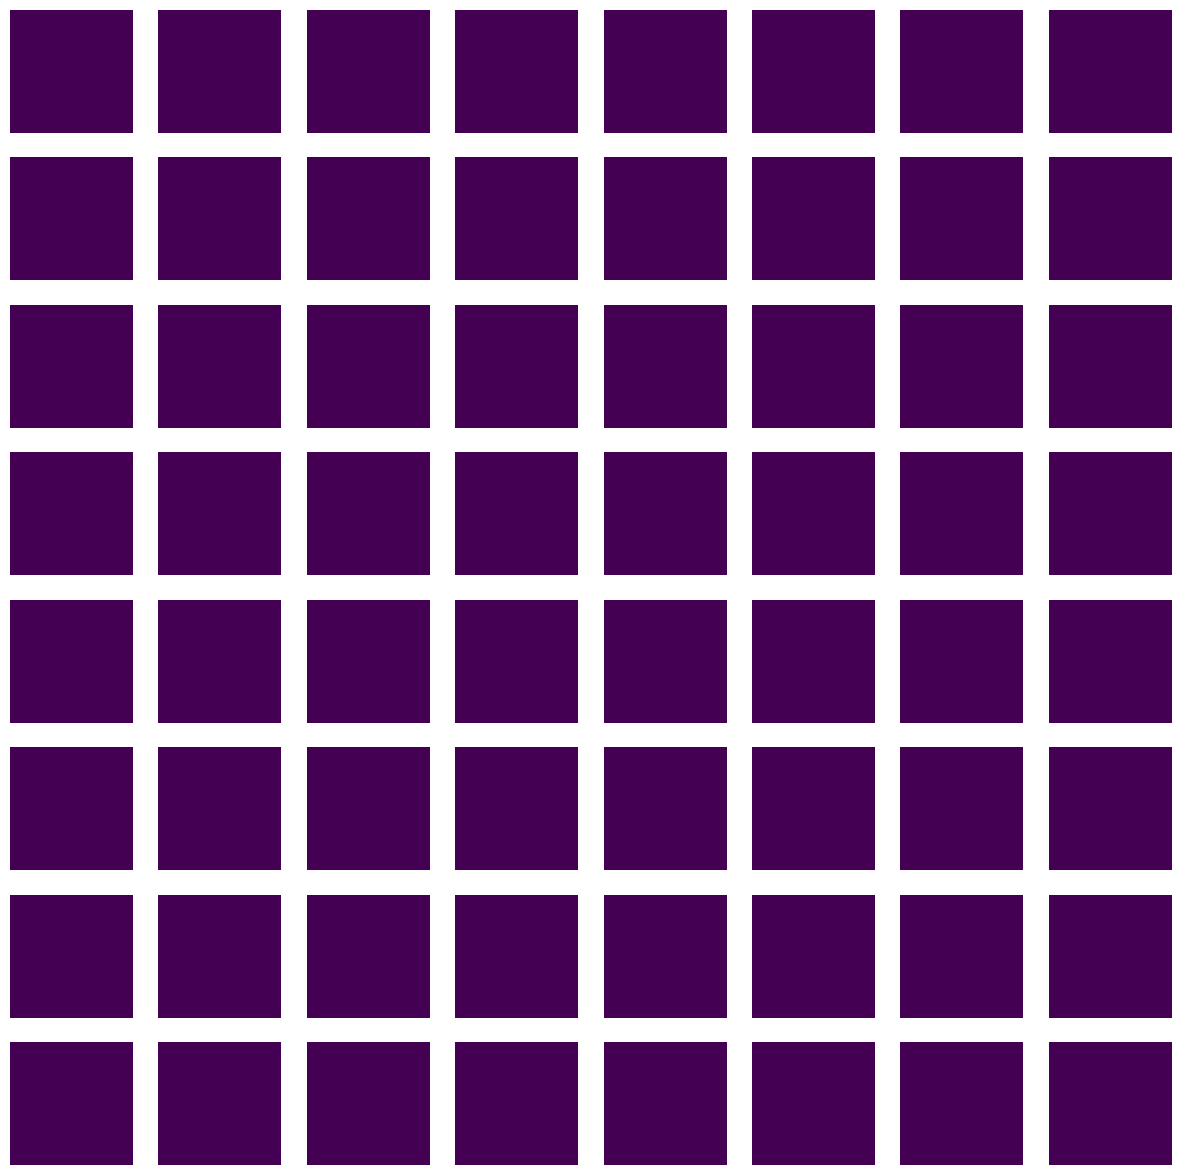

In [64]:
fig, axes = plt.subplots(8,8, figsize=(15,15))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(state.state["precalc_filter"]["GaborLayerLogSigma__0"]["kernel"][:,:,0,i])
    ax.axis("off")
plt.show()

In [59]:
kernel = state.state["precalc_filter"]["GaborLayerLogSigma_0"]["kernel"]
kernel.shape

(31, 31, 6, 64)

In [60]:
kernel_f_fft = jnp.fft.fftn(kernel[:,:,0,:], axes=(0,1))
kernel_f_fft = jnp.fft.fftshift(kernel_f_fft)
kernel_f_fft_abs_sum = jnp.abs(kernel_f_fft).sum(axis=-1)
kernel_f_fft.shape, kernel_f_fft_abs_sum.shape

((31, 31, 64), (31, 31))

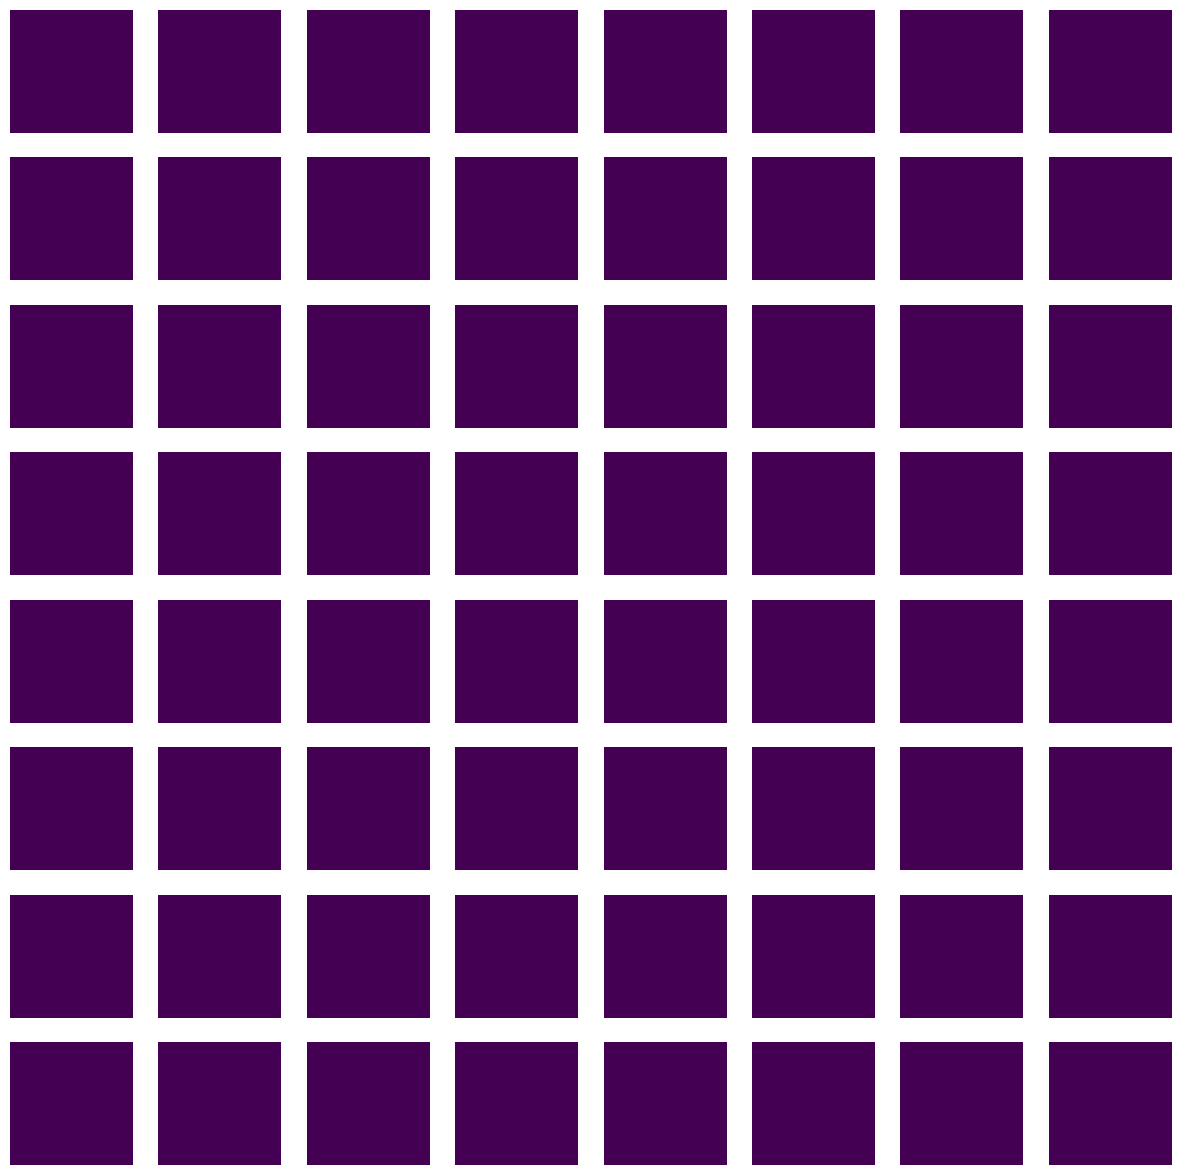

In [61]:
fig, axes = plt.subplots(8,8, figsize=(15,15))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(jnp.abs(kernel_f_fft[:,:,i]))
    ax.axis("off")
plt.show()

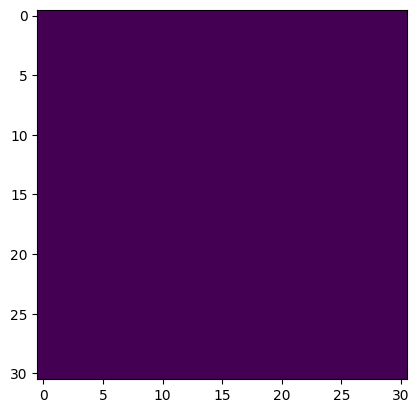

In [62]:
plt.imshow(kernel_f_fft_abs_sum)
plt.show()